# Pycaret를 사용한 미상환 / 상환 예측 분류 모델 Warming Up

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from category_encoders import BinaryEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.metrics import fbeta_score, roc_auc_score
import time
import shap

In [2]:
df = pd.read_csv('loan_data.csv', low_memory=False)
df_ind = df[(df.application_type == "Individual")]

In [3]:
#150개 열 중 선택한 열 41개
select_features = ["loan_amnt", "term", "int_rate", "installment", "grade", 
                   "emp_length", "home_ownership", "verification_status", "purpose", "addr_state", 
                   "dti", "delinq_2yrs", "fico_range_low", "fico_range_high", "inq_last_6mths", 
                   "open_acc", "pub_rec", "revol_util", "total_acc", "last_fico_range_high", 
                   "last_fico_range_low", "collections_12_mths_ex_med", "acc_now_delinq", "acc_open_past_24mths", "avg_cur_bal", 
                   "bc_util", "chargeoff_within_12_mths", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mort_acc", 
                   "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_op_rev_tl", 
                   "num_rev_accts", "num_rev_tl_bal_gt_0", "num_sats", "pct_tl_nvr_dlq", "percent_bc_gt_75", 
                   "loan_status"]

target = "loan_status"

In [4]:
df = df_ind[select_features].dropna()
X, y = df.loc[:, [column for column in df.columns if column != target]], df.loan_status
#Charged Off : 1 / Fully Paid : 0으로 라벨인코딩
binary_y = y.replace({'Charged Off': 1, 'Fully Paid': 0})
X_train, X_1, label_y_train, label_y_1 = train_test_split(X, binary_y, test_size=0.2, random_state=6, stratify=binary_y)
X_val, X_test, y_val, y_test = train_test_split(X_1, label_y_1, test_size=0.5, random_state=6, stratify=label_y_1)

## Pycaret을 활용하기 위한 환경 설정 (set_up) 

In [5]:
#pycaret은 타겟 레이블을 포함한 데이터프레임 전달함
data = pd.concat((X_train, label_y_train), axis=1)
test = pd.concat((X_val, y_val), axis=1)

### **preprocessing function**

- 전처리 함수를 정의하여 pycaret에 데이터셋을 넣기전 데이터 셋 커스텀 전처리.

In [6]:
import numpy as np

def new_features(df):
    transformed_df = df.copy()
    #전체 bc중에서 만족스런 bc 비율 특성 생성
    transformed_df['bc_sats_util'] = (transformed_df['num_bc_sats'] / transformed_df['num_bc_tl']) * 100
    transformed_df.drop(columns=['num_bc_tl'], axis=1, inplace=True)

    #최대값 3으로 제한
    transformed_df['delinq_2yrs'] = transformed_df['delinq_2yrs'].apply(lambda x: min(x, 3))
    transformed_df['pub_rec'] = transformed_df['pub_rec'].apply(lambda x: min(x, 3))
    
     #균등한 5개의 구간화
    transformed_df['dti_level'] = pd.qcut(transformed_df['dti'],5, labels=[1,2,3,4,5]) 
    transformed_df.drop(columns=['dti'],  inplace=True)
    
    #비율 특성 0~100으로 제한
    for col in ['revol_util', 'bc_sats_util', 'bc_util','percent_bc_gt_75','pct_tl_nvr_dlq']:
        transformed_df[col] = np.clip(transformed_df[col], 0, 100)

    #CountEncoding
    state_counts = transformed_df['addr_state'].value_counts()
    transformed_df['addr_state_count'] = transformed_df['addr_state'].map(state_counts)
    transformed_df.drop(columns=['addr_state'], inplace=True)

    #1이상의 값이 매우 작아 이진화하여 사용
    for col in ['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'acc_now_delinq', 'inq_last_6mths']:
        try:
            transformed_df[col] = np.where(transformed_df[col] > 0, "Yes", "No")
        except KeyError as e:
            pass

    return transformed_df

In [7]:
#커스텀 전처리된 데이터 셋
pre1_data = new_features(data)
pre1_test = new_features(test)

# Pycaret OOP API

In [8]:
#분류기 객체 생성
exp = ClassificationExperiment()

## 범주형 인코딩별 성능 비교

### **1. CatBoostEncoder()**
RUN TIME :  1144  
**top 5 모델**  recall : 0.925
- Catboost Classifier (catboost) - 0.957
- Light Gradient Boosting Machine (lightgbm) -0.956
- Gradient Boosting Classifier (gbc) - 0.955
- Extreme Gradient Boosting (xgb) -0.955
- Ada Boost Classifier (ada) - 0.953
- Extra Trees Classifier (et) - 0.953

In [9]:
#pycaret setup 전처리 특성 분류에 따른 분류
nominal_features = ["term", "home_ownership", "purpose", "verification_status",
                    "inq_last_6mths", "chargeoff_within_12_mths", "acc_now_delinq",  "collections_12_mths_ex_med"]
ordinal_features = {"grade": ["G", "F", "E", "D", "C", "B", "A"], 
                    "emp_length": ["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"], 
                    "dti_level": ["1","2","3","4","5"]}

numeric_features = ['loan_amnt', 'int_rate', 'installment', 'delinq_2yrs', 'fico_range_low',
                   'fico_range_high', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
                   'last_fico_range_high', 'last_fico_range_low', 'acc_open_past_24mths',
                   'avg_cur_bal', 'bc_util', 'mo_sin_old_rev_tl_op',
                   'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_bc_tl',
                   'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_accts',
                   'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
                   'bc_sats_util', 'addr_state_count']

In [10]:
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features,
          max_encoding_ohe=False, 
          encoding_method=CatBoostEncoder(random_state=6), 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", #랜덤언더샘플링 진행
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9, #특성간 상관성이 0.9이상인 다중공선성을 갖는 특성 제거
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 37)"
5,Transformed train set shape,"(367620, 37)"
6,Transformed test set shape,"(116617, 37)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [11]:
#전처리된 데이터 프레임 확인가능 
exp.X_train_transformed

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,delinq_2yrs,fico_range_high,...,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_op_rev_tl,num_rev_accts,pct_tl_nvr_dlq,percent_bc_gt_75,bc_sats_util,dti_level,addr_state_count
305474,6000.0,0.0,7.89,6.0,3.0,0.197023,0.197023,0.197023,0.0,739.0,...,2.0,3.0,2.0,4.0,8.0,95.000000,0.000000,50.000000,-1.0,23997.0
548336,10000.0,0.0,11.39,5.0,10.0,0.197023,0.197023,0.598512,0.0,694.0,...,4.0,4.0,6.0,6.0,17.0,100.000000,0.000000,50.000000,-1.0,34021.0
1234152,12600.0,1.0,23.99,2.0,10.0,0.399008,0.065674,0.399008,0.0,679.0,...,4.0,8.0,5.0,13.0,19.0,95.699997,80.000000,71.428574,-1.0,136283.0
902102,5000.0,0.0,14.52,4.0,8.0,0.039405,0.171003,0.439405,0.0,684.0,...,2.0,3.0,2.0,4.0,4.0,100.000000,50.000000,100.000000,-1.0,30322.0
675034,24000.0,0.0,6.49,6.0,5.0,0.032837,0.098512,0.028146,0.0,694.0,...,4.0,4.0,6.0,9.0,14.0,100.000000,33.299999,75.000000,-1.0,76195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263263,9000.0,0.0,8.18,5.0,5.0,0.169628,0.144279,0.208285,0.0,724.0,...,1.0,2.0,1.0,5.0,25.0,100.000000,0.000000,11.111111,-1.0,11265.0
207911,5000.0,0.0,7.89,6.0,10.0,0.169627,0.209520,0.208285,0.0,679.0,...,2.0,3.0,4.0,10.0,24.0,94.699997,33.299999,40.000000,-1.0,30322.0
623000,32000.0,1.0,12.99,4.0,10.0,0.169627,0.234587,0.208284,1.0,679.0,...,6.0,9.0,7.0,13.0,19.0,94.099998,57.099998,77.777779,-1.0,6912.0
244058,12000.0,0.0,10.99,5.0,0.0,0.230315,0.144278,0.208283,0.0,694.0,...,5.0,5.0,5.0,5.0,8.0,100.000000,80.000000,71.428574,-1.0,136283.0


In [12]:
exp.get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x00000213B3732440>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x00000213B3732...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x00000213B3732...,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [13]:
#평가 메트릭 추가할 수 있음
exp.add_metric("f2", "F2-Score", fbeta_score, beta=2)

Name                                                          F2-Score
Display Name                                                  F2-Score
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                make_scorer(fbeta_score, beta=2)
Target                                                            pred
Args                                                       {'beta': 2}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: f2, dtype: object

In [14]:
#사용가능한 알고리즘 확인
exp.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [15]:
cell_start_time = time.time() #시작시간 기록
top5_models = exp.compare_models(exclude=["knn"], fold = 5, round = 3, sort = 'AUC', n_select = 5)
cell_end_time = time.time() #끝난시간 기록
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2-Score,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.888,0.956,0.926,0.652,0.765,0.695,0.713,0.854,7.050
catboost,CatBoost Classifier,0.889,0.956,0.924,0.654,0.766,0.695,0.713,0.854,37.914
gbc,Gradient Boosting Classifier,0.888,0.955,0.925,0.652,0.765,0.695,0.713,0.854,45.778
xgboost,Extreme Gradient Boosting,0.888,0.955,0.924,0.652,0.765,0.694,0.712,0.853,8.178
ada,Ada Boost Classifier,0.882,0.953,0.928,0.639,0.756,0.682,0.703,0.851,15.326
et,Extra Trees Classifier,0.889,0.953,0.922,0.655,0.766,0.696,0.713,0.852,20.040
lda,Linear Discriminant Analysis,0.895,0.952,0.908,0.673,0.773,0.707,0.720,0.849,4.740
rf,Random Forest Classifier,0.888,0.951,0.924,0.653,0.765,0.694,0.712,0.853,26.238
lr,Logistic Regression,0.892,0.948,0.894,0.669,0.766,0.697,0.710,0.838,16.128
nb,Naive Bayes,0.878,0.931,0.848,0.645,0.733,0.656,0.666,0.798,5.784


CELL RUN TIME :  1743.4509100914001


### **2. OnehotEncoder()**
RUN TIME :  977  
**top 5 모델** recall : 0.925 accuracy : 0.890

- Catboost Classifier (catboost) - 0.957
- Light Gradient Boosting Machine (lightgbm) -0.956
- Extreme Gradient Boosting (xgb) -0.956
- Gradient Boosting Classifier (gbc) - 0.955
- Ada Boost Classifier (ada) - 0.953
- Extra Trees Classifier (et) - 0.953
- Random Forest Classifier (rf) - 0.953

In [16]:
#pycaret 카테고리 인코딩 디폴트는 onehot인코딩
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features, 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", 
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9,
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 57)"
5,Transformed train set shape,"(367620, 57)"
6,Transformed test set shape,"(116617, 57)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [17]:
cell_start_time = time.time() #시작시간 기록
top5_models = exp.compare_models(include=["gbc", "catboost", "lightgbm", "xgboost","ada", "et", "rf"], fold = 5, round = 3, sort = 'AUC', n_select = 5)
cell_end_time = time.time() #끝난시간 기록
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.889,0.957,0.925,0.654,0.767,0.696,0.714,47.408
lightgbm,Light Gradient Boosting Machine,0.888,0.956,0.926,0.652,0.766,0.695,0.713,10.648
xgboost,Extreme Gradient Boosting,0.888,0.956,0.924,0.653,0.765,0.695,0.713,14.610
gbc,Gradient Boosting Classifier,0.888,0.955,0.925,0.652,0.765,0.694,0.713,89.960
ada,Ada Boost Classifier,0.882,0.953,0.928,0.639,0.756,0.682,0.703,30.840
et,Extra Trees Classifier,0.889,0.952,0.918,0.656,0.765,0.695,0.712,28.252
rf,Random Forest Classifier,0.887,0.952,0.925,0.651,0.764,0.693,0.711,26.338


CELL RUN TIME :  1931.1908695697784


### **3. BinaryEncoder()**
RUN TIME :  1144  
**top 5 모델**  recall : 0.925
- Catboost Classifier (catboost) - 0.957
- Light Gradient Boosting Machine (lightgbm) -0.956
- Gradient Boosting Classifier (gbc) - 0.955
- Extreme Gradient Boosting (xgb) -0.955
- Ada Boost Classifier (ada) - 0.953
- Extra Trees Classifier (et) - 0.953

In [18]:
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features,
          max_encoding_ohe=False, 
          encoding_method=BinaryEncoder(), 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", 
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9, 
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 43)"
5,Transformed train set shape,"(367620, 43)"
6,Transformed test set shape,"(116617, 43)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [19]:
cell_start_time = time.time() #시작시간 기록
top5_models = exp.compare_models(exclude=["knn"], fold = 5, round = 3, sort = 'AUC', n_select = 5)
cell_end_time = time.time() #끝난시간 기록
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.889,0.957,0.925,0.655,0.767,0.697,0.715,69.658
xgboost,Extreme Gradient Boosting,0.888,0.956,0.925,0.653,0.765,0.695,0.713,15.398
lightgbm,Light Gradient Boosting Machine,0.888,0.956,0.926,0.652,0.766,0.695,0.713,14.438
gbc,Gradient Boosting Classifier,0.888,0.955,0.925,0.652,0.765,0.694,0.713,103.478
ada,Ada Boost Classifier,0.883,0.953,0.927,0.639,0.757,0.683,0.703,33.940
rf,Random Forest Classifier,0.888,0.952,0.925,0.652,0.765,0.694,0.712,24.178
lda,Linear Discriminant Analysis,0.895,0.952,0.908,0.673,0.773,0.707,0.720,11.902
et,Extra Trees Classifier,0.889,0.952,0.919,0.656,0.766,0.696,0.713,52.630
lr,Logistic Regression,0.892,0.948,0.893,0.669,0.765,0.697,0.709,17.270
nb,Naive Bayes,0.878,0.931,0.849,0.644,0.732,0.655,0.666,6.754


CELL RUN TIME :  2740.3660163879395


## -------

## 수치형 변수 스케일링 방법 성능 비교
- 범주형 인코딩 : 가장 성능이 좋고 빨랐던 OneHotEncoding 사용
- 데이터 셋에 이상치와 왜도가 있는 특성이 있어 이를 고려한 스케일링 방법 고려
  1. robust: 사분위수를 기준으로 스케일링하기 때문에 이상치에 민감하지 않는 스케일링 방법
  2. transformation : 가우시안 분포로 만들어 주는 스케일링. yeo-johnson의 경우는 BoxCox의 확장으로 음수, 양수 모두 적용 가능한 스케일링.

### **1. Robust Scaling**

RUN TIME :  732  
**top 5 모델** recall : 0.925 accuracy : 0.889
- Catboost Classifier (catboost) - 0.957
- Light Gradient Boosting Machine (lightgbm) -0.956
- Extreme Gradient Boosting (xgb) -0.956
- Gradient Boosting Classifier (gbc) - 0.955
- Ada Boost Classifier (ada) - 0.953
- Extra Trees Classifier (et) - 0.953
- Random Forest Classifier (rf) - 0.953

In [20]:
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features, 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", 
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9,
          normalize = True,
          normalize_method = 'robust', #디폴트는 zscore
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 57)"
5,Transformed train set shape,"(367620, 57)"
6,Transformed test set shape,"(116617, 57)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [21]:
cell_start_time = time.time() 
exp.compare_models(include=["gbc", "catboost", "lightgbm", "xgboost","ada", "et", "rf"], fold = 5, round = 3, sort = 'AUC')
cell_end_time = time.time() 
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.889,0.957,0.925,0.655,0.767,0.697,0.715,40.948
lightgbm,Light Gradient Boosting Machine,0.888,0.956,0.926,0.653,0.766,0.695,0.714,9.830
xgboost,Extreme Gradient Boosting,0.888,0.956,0.924,0.653,0.765,0.695,0.713,9.462
gbc,Gradient Boosting Classifier,0.888,0.955,0.925,0.652,0.765,0.694,0.713,78.086
ada,Ada Boost Classifier,0.882,0.953,0.928,0.639,0.756,0.682,0.703,18.438
et,Extra Trees Classifier,0.889,0.952,0.918,0.656,0.765,0.695,0.712,24.410
rf,Random Forest Classifier,0.887,0.952,0.925,0.651,0.764,0.693,0.712,24.374


CELL RUN TIME :  1099.2663679122925


### **2. scaling : transformation= True (yeo-johnson)**

RUN TIME :  732  
**top 5 모델** recall : 0.925 accuracy : 0.889
- Catboost Classifier (catboost) - 0.957
- Light Gradient Boosting Machine (lightgbm) -0.956
- Extreme Gradient Boosting (xgb) -0.956
- Gradient Boosting Classifier (gbc) - 0.955
- Ada Boost Classifier (ada) - 0.953
- Extra Trees Classifier (et) - 0.953
- Random Forest Classifier (rf) - 0.953

In [22]:
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features, 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", 
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9,
          transformation = True, #디폴트값 yeo-johnson method
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 57)"
5,Transformed train set shape,"(367620, 57)"
6,Transformed test set shape,"(116617, 57)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [23]:
cell_start_time = time.time() 
exp.compare_models(include=["gbc", "catboost", "lightgbm", "xgboost","ada", "et", "rf"], fold = 5, round = 3, sort = 'AUC')
cell_end_time = time.time() 
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.889,0.956,0.925,0.655,0.767,0.696,0.714,41.800
lightgbm,Light Gradient Boosting Machine,0.888,0.956,0.926,0.652,0.766,0.695,0.713,15.068
gbc,Gradient Boosting Classifier,0.888,0.955,0.925,0.652,0.765,0.694,0.712,51.416
xgboost,Extreme Gradient Boosting,0.888,0.955,0.924,0.653,0.765,0.695,0.713,16.290
ada,Ada Boost Classifier,0.882,0.953,0.928,0.638,0.756,0.682,0.703,24.654
et,Extra Trees Classifier,0.889,0.952,0.918,0.656,0.765,0.695,0.712,30.766
rf,Random Forest Classifier,0.887,0.952,0.924,0.651,0.764,0.693,0.711,30.924


CELL RUN TIME :  1150.030000925064


## **모델 생성 create_model** - OneHot / robust Scale

<h3/>create_model(estimator = None, ensemble = False, method = None, fold = 10, round = 4, cross_validation = True, verbose = True, system = True, **kwargs)</h3>

- estimator : 어떤 모델을 사용할 것인가?
- ensemble : estimator를 앙상블 한 결과를 나타냅니다.
- method : bagging, boosting 선택 가능합니다.
- fold : K-fold의 수로, 최소 2 이상의 숫자를 입력합니다.
- round : 점수 반올림으로 표시할 자리를 적습니다.
- cross_validation : True로 설정하면 cross_validation을 사용합니다.
- verbose : True로 설정하면 진행중인 상황이 나타납니다.
- system : internal function으로 인해 바뀌는 것을 제외하고는 항상 True를 입력해야 합니다.

In [24]:
exp.setup(data=pre1_data, 
          target=target, 
          test_data=pre1_test , 
          ordinal_features=ordinal_features, 
          numeric_features=numeric_features, 
          categorical_features=nominal_features, 
          fix_imbalance=True, 
          fix_imbalance_method="RandomUnderSampler", 
          transformation = True,
          remove_multicollinearity= True,
          multicollinearity_threshold = 0.9,
          fold=3, 
          session_id=6)

,Description,Value
0,Session id,6
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(1049553, 41)"
4,Transformed data shape,"(484237, 57)"
5,Transformed train set shape,"(367620, 57)"
6,Transformed test set shape,"(116617, 57)"
7,Ordinal features,8
8,Numeric features,29
9,Categorical features,8


In [25]:
#가장 성능이 높았던 catboost 알고리즘 선택
model = exp.create_model('catboost', return_train_score=True)

## **모델 튜닝  Tune Models**

<h3/>tune_model(estimator = None, fold = 10, round = 4, n_iter = 10, custom_grid = None, optimize = ‘Accuracy’, choose_better = False, verbose = True) </h3>

- estimator : 사용할 모델을 입력합니다.
- fold : K-fold의 수로, 최소 2 이상의 숫자를 입력합니다.
- round : 점수 반올림으로 표시할 자리를 적습니다.
- n_iter : Random Grid Search를 한 회차당 반복할 회수입니다.
- custom_grid : 직접 파라미터의 범위를 조정할 수 있습니다.
- optimize : 파라미터 튜닝 과정에서 어떤 점수를 따라갈 것인지 선택 가능합니다. 'Accuracy','AUC','Recall','Precision', 'F1'
- choose_better : True로 설정하면 성능이 높아지지 않을 경우 tuning을 하지 않은 모델을 반환합니다.
- verbose : True로 설정하면 진행중인 상황이 나타납니다.

In [26]:
# 모델 하이퍼 파라미터 튜닝
best_model = exp.tune_model(model, optimize = 'AUC', return_train_score=True, return_tuner=True, choose_better=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
#모델 성능평가/해석에 대한 인터페이스 제공
exp.evaluate_model(best_model[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## **모델 저장 finalize_model -> save_model -> load_model**

In [28]:
best = exp.finalize_model(best_model[0])  #full pipeline 반환 할 때 finalize_model 사용

In [29]:
exp.save_model(best, 'my_model') #피클파일로 모델 저장 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['loan_amnt', 'int_rate',
                                              'installment', 'delinq_2yrs',
                                              'fico_range_low',
                                              'fico_range_high', 'open_acc',
                                              'pub_rec', 'revol_util',
                                              'total_acc',
                                              'last_fico_range_high',
                                              'last_fico_range_low',
                                              'acc_open_past_24mths',
                                              'avg_cur_bal', 'bc_util',
                                              'mo_sin_old_rev_tl_...
                                     transformer=FixImbalancer(estimator=RandomUnderSampler(random_sta

In [30]:
# 모델 로드
saved_model = exp.load_model('my_model')

Transformation Pipeline and Model Successfully Loaded


In [31]:
# sklearn 의 파이프라인이 아닌 pycaret의 파이프라인임
type(saved_model)

pycaret.internal.pipeline.Pipeline

## **모델 분석 - 시각화**

### **feature importance**

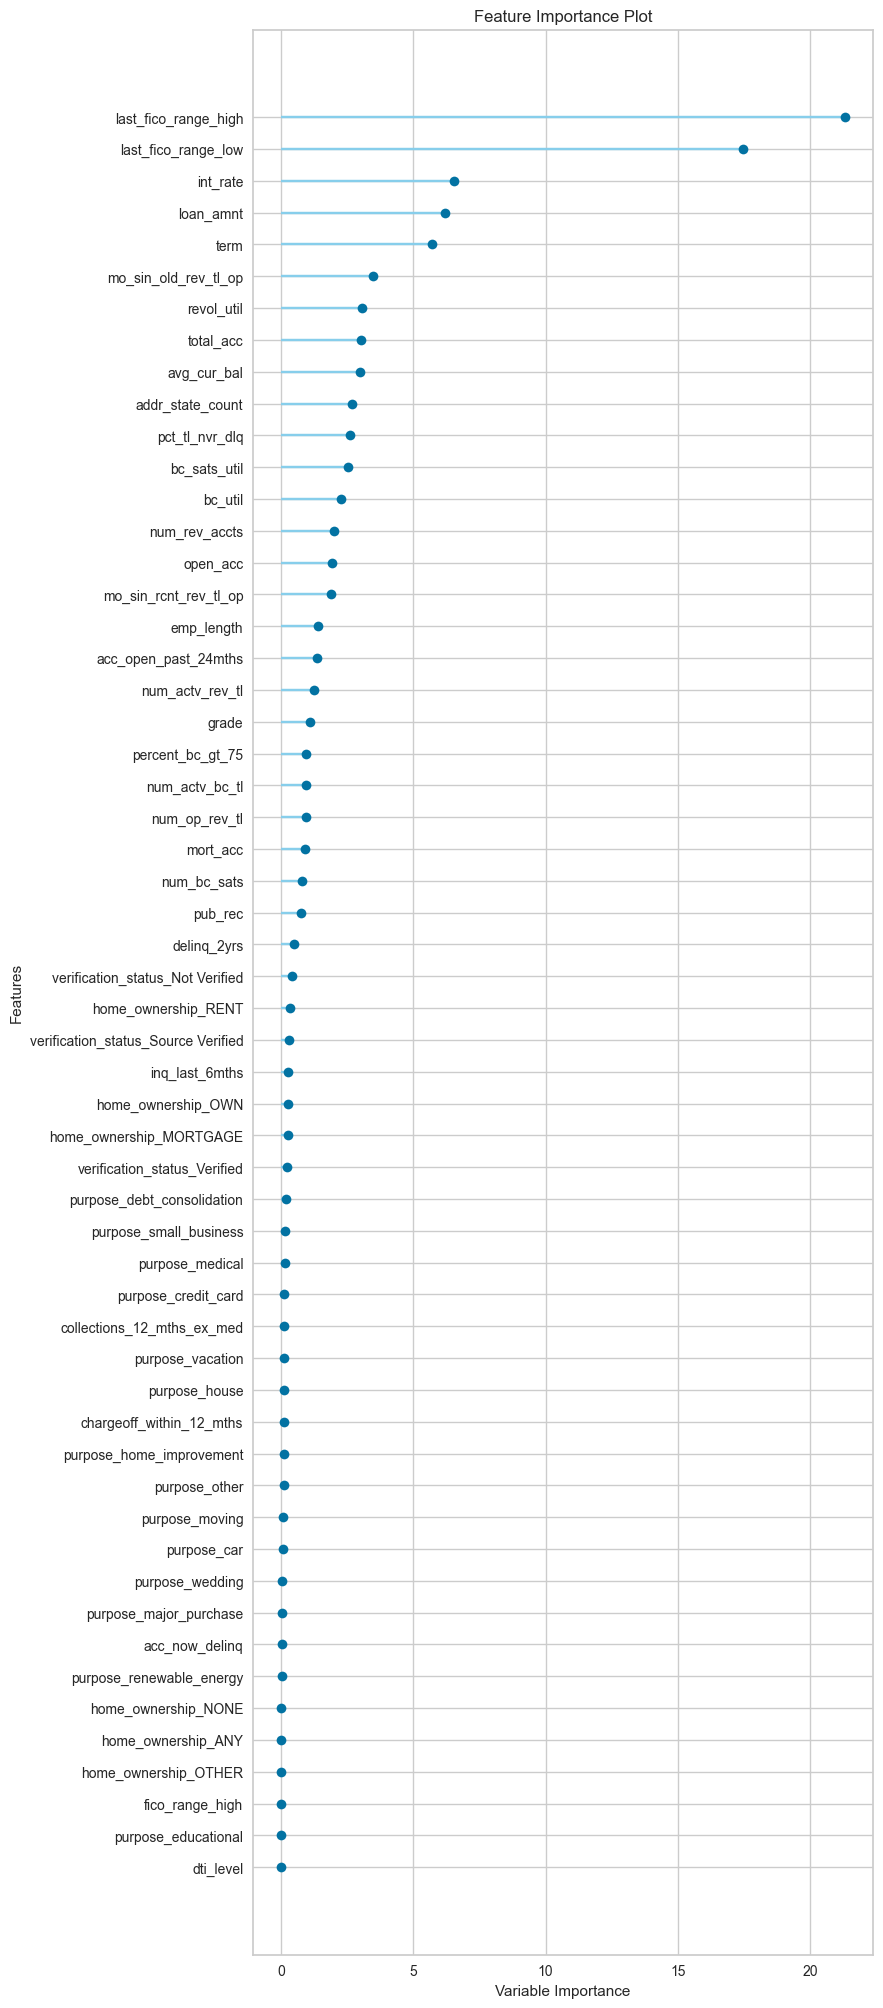

In [32]:
exp.plot_model(model, plot='feature_all')

### **Output Report - SHAP**

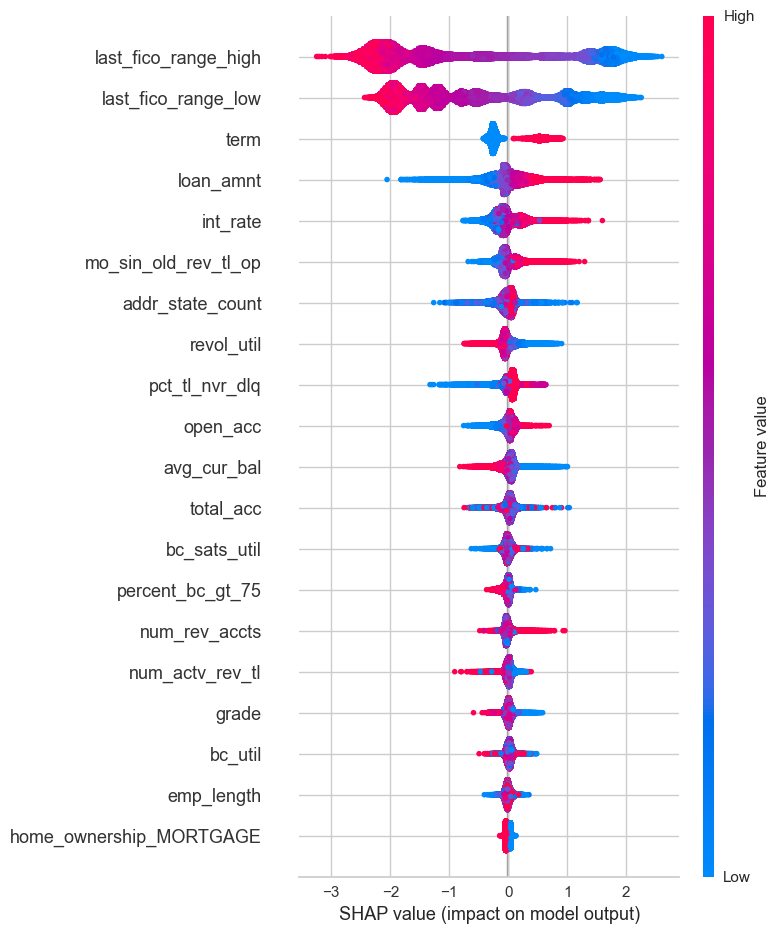

In [33]:
exp.interpret_model(model, plot='summary')